([<matplotlib.axis.XTick at 0x11e224470>,
 <a list of 3 Text xticklabel objects>)

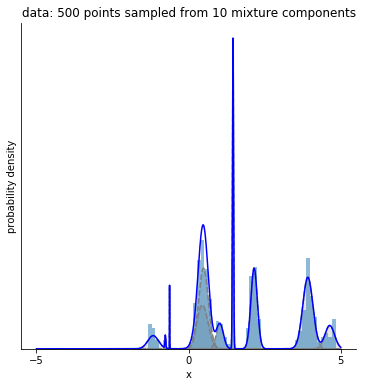

In [1]:
# RJMC for GMMs:
import matplotlib.pyplot as plt
%matplotlib inline

from autograd import numpy as np
np.random.seed(0)
from scipy.stats import norm
from scipy.stats import dirichlet
from scipy.special import logsumexp

def gaussian_mixture_log_likelihood(X, means, stdevs, weights):
    component_log_pdfs = np.array([norm.logpdf(X, loc=mean, scale=stdev) + np.log(weight) for ((mean, stdev), weight) in zip(zip(means, stdevs), weights)])
    return np.sum(logsumexp(component_log_pdfs, 0))

from scipy.stats import norm, invgamma
from scipy.special import logsumexp

def unpack(theta):
    assert(len(theta) % 3 == 0)
    n = int(len(theta) / 3)
    means, stdevs, weights = np.array(theta[:n]), np.array(theta[n:2*n]), np.array(theta[2*n:])
    return means, stdevs, weights

def log_prior(theta):
    means, stdevs, weights = unpack(theta)
    log_prior_on_means = np.sum(norm.logpdf(means, scale=20))
    log_prior_on_variances = np.sum(invgamma.logpdf((stdevs**2), 1.0))
    #log_prior_on_weights = dirichlet.logpdf(weights, np.ones(len(weights)))
    #log_prior_on_weights = np.sum(np.log(weights))
    log_prior_on_weights = 0 # removing the prior on weights to see if this is the culprit...
    return log_prior_on_means + log_prior_on_variances + log_prior_on_weights

def flat_log_p(theta):
    means, stdevs, weights = unpack(theta)
    if np.min(stdevs) <= 0.001: return - np.inf
    log_likelihood = gaussian_mixture_log_likelihood(X=data, means=means,
                                           stdevs=stdevs,
                                           weights=weights)
    
    return log_likelihood + log_prior(theta)

n_components = 10
true_means = np.random.rand(n_components) * 10 - 5
true_stdevs = np.random.rand(n_components) * 0.2
true_weights = np.random.rand(n_components)**2
true_weights /= np.sum(true_weights)

n_data = 500
data = np.zeros(n_data)
for i in range(n_data):
    component = np.random.choice(np.arange(n_components), p=true_weights)
    #component = np.random.randint(n_components)
    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])

plt.figure(figsize=(6,6))

ax = plt.subplot(111)
    
plt.hist(data, bins=50, normed=True, alpha=0.5);
x = np.linspace(-5,5, 1000)
y_tot = np.zeros(x.shape)
for i in range(n_components):
    
    y = norm.pdf(x, loc=true_means[i], scale=true_stdevs[i]) * true_weights[i]
    plt.plot(x, y, '--', color='grey',)
    plt.fill_between(x, y, color='grey' ,alpha=0.2)
    y_tot += y
plt.plot(x,y_tot, color='blue',)
plt.yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("data: {} points sampled from {} mixture components".format(n_data, n_components))
plt.ylabel('probability density')
plt.xlabel('x')
plt.xticks([-5,0,5])

In [2]:
np.mean(data), np.std(data)

(1.7910542863676069, 1.633982672102031)

In [3]:
max_components = 50
mean_perturbation_scale = 0.0001
stdev_perturbation_scale = 0.0001


def reversible_birth_death_move(theta, parents):
    
    means, stdevs, weights = unpack(theta)
    means, stdevs, weights = map(np.array, (means, stdevs, weights))
    
    sum_weights_before = np.sum(weights)
    n_components = len(means)
    
    # decide whether to create a new 
    if n_components == 1:
        birth_probability = 1.0
    elif n_components == max_components:
        birth_probability = 0.0
    else:
        birth_probability = 0.5
    death_probability = 1.0 - birth_probability
    
    if np.random.rand() < birth_probability:
        (means, stdevs, weights, parents_prime), log_jac_u_term = reversible_birth_move(means, stdevs, weights, parents)
    else:
        (means, stdevs, weights, parents_prime), log_jac_u_term = reversible_death_move(means, stdevs, weights, parents)
    assert(len(means) == len(stdevs))
    theta_prime = np.array(means + stdevs + weights)
    
    sum_weights_after = np.sum(weights)
    assert(np.isclose(sum_weights_before, sum_weights_after))
    return theta_prime, parents_prime, log_jac_u_term
    
from scipy.stats import uniform, norm
u_1_distribution = uniform(0, 1)
u_2_distribution = norm(0, 1)
u_3_distribution = norm(0, 1)


def reversible_birth_move(means, stdevs, weights, parents):
    # make local copies to be extra sure we're not accidentally overwriting...
    means, stdevs, weights, parents = map(list, (means, stdevs, weights, parents))
    
    # draw all the random numbers we're going to use
    i = np.random.randint(len(means)) # choose a parent component at random
    u_1 = u_1_distribution.rvs()
    u_2 = u_2_distribution.rvs()
    u_3 = u_3_distribution.rvs()
    
    # compute the log probability density of all the random numbers we drew
    log_prob_u = np.log(1.0 / len(means)) + u_1_distribution.logpdf(u_1) + u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # compute the parameters of the new mixture component
    weight_new = weights[i] * u_1
    mean_new = (u_2 * mean_perturbation_scale) + means[i]
    stdev_new = (u_3 * stdev_perturbation_scale) + stdevs[i]
    
    # compute log determinant of the jacobian
    log_jacobian_determinant = np.log(weights[i]) + np.log(mean_perturbation_scale) + np.log(stdev_perturbation_scale)
    
    # subtract the new mixture component's weight from its parent
    weights[i] -= weight_new
    
    # update means, stdevs, weights, parents
    means.append(mean_new)
    stdevs.append(stdev_new)
    weights.append(weight_new)
    parents.append(i)
    
    return (means, stdevs, weights, parents), (log_jacobian_determinant - log_prob_u)
    
def reversible_death_move(means, stdevs, weights, parents):
    # make local copies to be extra sure we're not accidentally overwriting...
    means, stdevs, weights, parents = map(list, (means, stdevs, weights, parents))
    
    # draw all the random numbers we're going to use
    i = np.random.randint(1, len(means)) # choose a component at random to remove, except component 0
    
    # compute the log probability density of all the random numbers we drew
    log_prob_u = np.log(1.0 / (len(means) - 1))
    
    # remove this mixture component, and re-allocate its weight to its parent
    weights[parents[i]] += weights[i]
    
    # update the parent list, so that any j whose parent just got deleted is assigned a new parent
    for j in range(1, len(parents)):
        if parents[j] == i:
            parents[j] = parents[i]
            
    # wait, this is almost certainly wrong, because the indices will change...
    _ = means.pop(i)
    _ = stdevs.pop(i)
    _ = weights.pop(i)
    _ = parents.pop(i)
    
    # fix indices
    for j in range(1, len(parents)):
        if parents[j] > i:
            parents[j] -= 1
    
    return (means, stdevs, weights, parents), (- log_prob_u)

from tqdm import tqdm
def rjmcmc_w_parents(theta, parents, n_steps=10000):
    
    traj = [(theta, parents)]
    old_log_p = flat_log_p(theta)
    
    for t in tqdm(range(n_steps)):
        # generate proposal
        if np.random.rand() < 0.1:
            theta_prime, parents_prime, log_jac_u_term = reversible_birth_death_move(theta, parents)
        else:
            theta_prime = np.array(theta)
            
            n = int(len(theta) / 3)
            
            # different proposal sizes for mean, stdev, weight
            theta_prime[:n] += np.random.randn(n) * 1.0
            theta_prime[n:2*n] += np.random.randn(n) * 0.1
            theta_prime[2*n:] += np.random.randn(n) * 0.1
            
            # make sure the standard deviations are okay
            theta_prime[n:2*n] = np.abs(theta_prime[2*n:])
            
            
            # make sure the weights are okay
            theta_prime[2*n:] = np.abs(theta_prime[2*n:])
            while not np.isclose(np.sum(theta_prime[2*n:]), 1.0):
                theta_prime[2*n:] = theta_prime[2*n:] / np.sum(theta_prime[2*n:])
            #assert(np.max(theta_prime[2*n:]) <= 1)
            #assert(np.max(theta_prime[2*n:]) >= 0)
            #assert(np.sum(theta_prime[2*n:] == 1.0))
            # hacky fix: otherwise this always will raise:
            # ValueError: The input vector 'x' must lie within the normal simplex. but np.sum(x, 0) = 0.946... or similar
            
            # and sometimes also raise:
            #ValueError: Each entry in 'x' must be greater than zero.
            
            parents_prime = parents
            log_jac_u_term = 0.0
           
        
        new_log_p = flat_log_p(theta_prime)
        log_prob_ratio = new_log_p - old_log_p
        if not np.isfinite(new_log_p):
            A = 0
            #print(RuntimeWarning("new_log_p isn't finite: theta = {}, parents = {}".format(theta_prime, parents_prime)))
        else:
            A = min(1.0, np.exp(log_prob_ratio + log_jac_u_term))
    
        if np.random.rand() < A:
            theta = theta_prime
            parents = parents_prime
            old_log_p = new_log_p
            
            if len(theta) != len(traj[-1][0]):
                prev_dim = int(len(traj[-1][0]) / 3)
                current_dim = int(len(theta) / 3)
                assert(len(theta) % 3 == 0)

                print('{}: accepted a cross-model jump! # components: {} --> {}'.format(t, prev_dim, current_dim))
        traj.append((theta, parents))
    return traj

In [4]:
np.random.seed(0)
init_n_components = 1
init_means = np.zeros(init_n_components)
init_stdevs = np.random.rand(init_n_components)
init_weights = np.random.rand(init_n_components)
init_weights /= np.sum(init_weights)
init_theta = np.hstack([init_means, init_stdevs, init_weights])
init_parents = [None]
traj = rjmcmc_w_parents(init_theta, init_parents, n_steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
100%|██████████| 10000/10000 [00:07<00:00, 1325.50it/s]


In [5]:
traj[0]

(array([0.       , 0.5488135, 1.       ]), [None])

In [6]:
traj[-1]

(array([1.75846233, 1.27398307, 1.        ]), [None])

In [7]:
X = np.vstack([x[0][:2] for x in traj if len(x[0]) == 3])

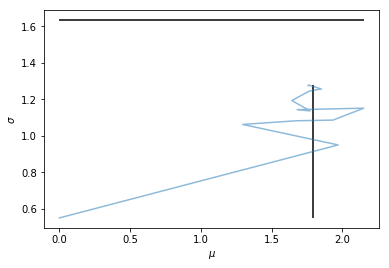

In [8]:
plt.plot(X[:,0], X[:,1], alpha=0.5)


plt.vlines(np.mean(data), min(X[:,1]), max(X[:,1]))
plt.hlines(np.std(data), min(X[:,0]), max(X[:,0]))
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

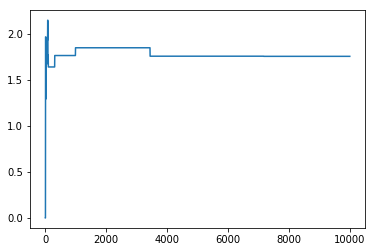

In [9]:
plt.plot(X[:,0])

In [10]:
# okay that looks fine...

In [11]:
np.random.seed(1)
init_n_components = 50
init_means = np.random.randn(init_n_components)
init_stdevs = np.random.rand(init_n_components) + 1
init_weights = np.random.rand(init_n_components)
init_weights /= np.sum(init_weights)
init_theta = np.hstack([init_means, init_stdevs, init_weights])
init_parents = [None] + list(range(init_n_components - 1))
traj = rjmcmc_w_parents(init_theta, init_parents, n_steps=10000)

  0%|          | 31/10000 [00:00<01:13, 136.40it/s]

9: accepted a cross-model jump! # components: 50 --> 49
10: accepted a cross-model jump! # components: 49 --> 48
25: accepted a cross-model jump! # components: 48 --> 47


  1%|          | 120/10000 [00:00<00:59, 165.55it/s]

84: accepted a cross-model jump! # components: 47 --> 46
109: accepted a cross-model jump! # components: 46 --> 45


  2%|▏         | 180/10000 [00:01<00:54, 180.91it/s]

154: accepted a cross-model jump! # components: 45 --> 44
172: accepted a cross-model jump! # components: 44 --> 43
175: accepted a cross-model jump! # components: 43 --> 42
180: accepted a cross-model jump! # components: 42 --> 41
188: accepted a cross-model jump! # components: 41 --> 40


  2%|▏         | 240/10000 [00:01<00:53, 183.49it/s]

204: accepted a cross-model jump! # components: 40 --> 39
234: accepted a cross-model jump! # components: 39 --> 38
241: accepted a cross-model jump! # components: 38 --> 37


  3%|▎         | 309/10000 [00:01<00:46, 207.94it/s]

259: accepted a cross-model jump! # components: 37 --> 36
279: accepted a cross-model jump! # components: 36 --> 35


  4%|▎         | 358/10000 [00:01<00:44, 217.58it/s]

312: accepted a cross-model jump! # components: 35 --> 34
322: accepted a cross-model jump! # components: 34 --> 33
329: accepted a cross-model jump! # components: 33 --> 32
335: accepted a cross-model jump! # components: 32 --> 31
357: accepted a cross-model jump! # components: 31 --> 30


  4%|▍         | 445/10000 [00:02<00:37, 257.76it/s]

388: accepted a cross-model jump! # components: 30 --> 29
400: accepted a cross-model jump! # components: 29 --> 28


  5%|▍         | 499/10000 [00:02<00:37, 250.85it/s]

476: accepted a cross-model jump! # components: 28 --> 27


  6%|▌         | 603/10000 [00:02<00:37, 247.35it/s]

555: accepted a cross-model jump! # components: 27 --> 26
568: accepted a cross-model jump! # components: 26 --> 25
586: accepted a cross-model jump! # components: 25 --> 24
593: accepted a cross-model jump! # components: 24 --> 23
599: accepted a cross-model jump! # components: 23 --> 22
608: accepted a cross-model jump! # components: 22 --> 21

  7%|▋         | 670/10000 [00:03<00:32, 282.91it/s]


622: accepted a cross-model jump! # components: 21 --> 20
627: accepted a cross-model jump! # components: 20 --> 19
641: accepted a cross-model jump! # components: 19 --> 18
693: accepted a cross-model jump! # components: 18 --> 17


  8%|▊         | 784/10000 [00:03<00:27, 334.85it/s]

717: accepted a cross-model jump! # components: 17 --> 16


 11%|█         | 1067/10000 [00:04<00:22, 405.63it/s]

976: accepted a cross-model jump! # components: 16 --> 15
988: accepted a cross-model jump! # components: 15 --> 14
990: accepted a cross-model jump! # components: 14 --> 13
1039: accepted a cross-model jump! # components: 13 --> 12


 12%|█▏        | 1200/10000 [00:04<00:21, 417.20it/s]

1125: accepted a cross-model jump! # components: 12 --> 11
1159: accepted a cross-model jump! # components: 11 --> 10


 13%|█▎        | 1335/10000 [00:04<00:20, 421.65it/s]

1274: accepted a cross-model jump! # components: 10 --> 9
1339: accepted a cross-model jump! # components: 9 --> 8


 14%|█▍        | 1431/10000 [00:04<00:19, 449.89it/s]

1359: accepted a cross-model jump! # components: 8 --> 7
1367: accepted a cross-model jump! # components: 7 --> 6
1416: accepted a cross-model jump! # components: 6 --> 5
1445: accepted a cross-model jump! # components: 5 --> 4


 17%|█▋        | 1731/10000 [00:05<00:11, 702.39it/s]

1522: accepted a cross-model jump! # components: 4 --> 3
1529: accepted a cross-model jump! # components: 3 --> 2
1530: accepted a cross-model jump! # components: 2 --> 1


100%|██████████| 10000/10000 [00:11<00:00, 874.65it/s]


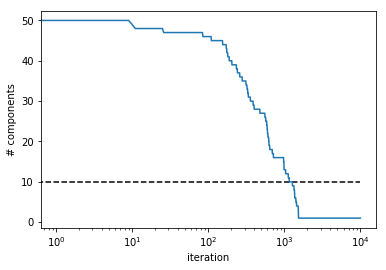

In [12]:
plt.plot([len(t[0]) / 3 for t in traj])
plt.hlines(n_components, 0, len(traj), linestyles='--')
plt.ylabel('# components')
plt.xlabel('iteration')
plt.xscale('log')

In [13]:
log_posterior = np.array([flat_log_p(t[0]) for t in traj])
log_prior = np.array([log_prior(t[0]) for t in traj])
log_likelihood = log_posterior - log_prior

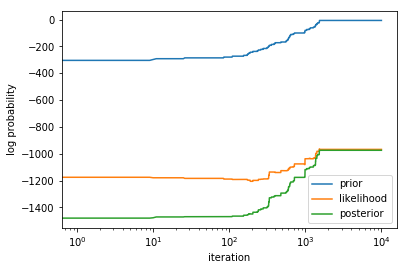

In [14]:
plt.plot(log_prior, label='prior')
plt.plot(log_likelihood, label='likelihood')
plt.plot(log_posterior, label='posterior')
plt.legend(loc='best')
plt.ylabel('log probability')
plt.xlabel('iteration')
plt.xscale('log')

(array([11.,  9.,  4.,  0.,  4.,  1.,  0.,  0.,  0.,  0.,  1.,  3., 20.,
        39., 48., 35., 22.,  4., 12., 11.,  5.,  2., 40.,  0.,  0.,  0.,
         9., 32., 36., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         4.,  8., 17., 40., 23., 14.,  3.,  5.,  7.,  5., 13.]),
 array([-1.33657694, -1.21305093, -1.08952491, -0.9659989 , -0.84247289,
        -0.71894687, -0.59542086, -0.47189484, -0.34836883, -0.22484281,
        -0.1013168 ,  0.02220922,  0.14573523,  0.26926125,  0.39278726,
         0.51631328,  0.63983929,  0.76336531,  0.88689132,  1.01041733,
         1.13394335,  1.25746936,  1.38099538,  1.50452139,  1.62804741,
         1.75157342,  1.87509944,  1.99862545,  2.12215147,  2.24567748,
         2.3692035 ,  2.49272951,  2.61625553,  2.73978154,  2.86330755,
         2.98683357,  3.11035958,  3.2338856 ,  3.35741161,  3.48093763,
         3.60446364,  3.72798966,  3.85151567,  3.97504169,  4.0985677 ,
         4.22209372,  4.34561973,  4.46914574,  4.59267176,

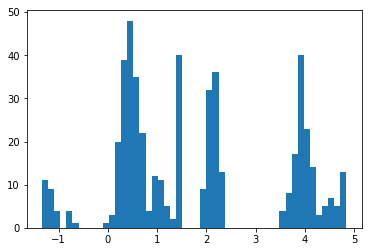

In [15]:
plt.hist(data, bins=50)

In [16]:
# that looks like an issue: maybe my likelihood is implemented incorrectly?